In [47]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd 
from modules import preprocess
from scipy.stats import gamma, norm

number_to_month = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "june", 7: "july", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"} 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Data import

#### Define the study crop and country

In [2]:
# USER INPUTS
ecmwf_country = "BR" # one of ["US", "BR"]
crop = "wheat" # one of ["maize", "wheat"]

shapefile_path, crop_season_in_days_of_year, crop_season_in_months, crop_season_in_time_steps, test_years = preprocess.set_crop_season(ecmwf_country, crop)

print(crop, ecmwf_country, crop_season_in_days_of_year, crop_season_in_months, crop_season_in_time_steps, test_years)

wheat BR (129, 329) (5, 11) (16, 41) [2006, 2015, 2017]


#### Read Data

<Axes: >

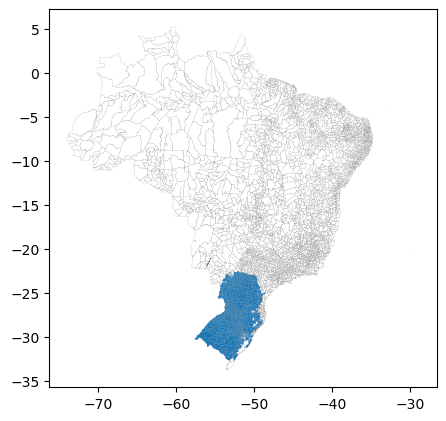

In [141]:
# CY-BENCH
yield_data = pd.read_csv("../data/CY-Bench/{}/{}/yield_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
era = pd.read_csv("../data/CY-Bench/{}/{}/meteo_{}_{}.csv".format(ecmwf_country, crop, crop, ecmwf_country))
relevant_adm_ids = yield_data["adm_id"].unique()

# Country shapefile
country_gpd = gpd.read_file(shapefile_path)
country_gpd = country_gpd.set_crs("EPSG:4326", allow_override=True) # allow override because US shapefile is already in 4326
country_gpd["adm_id"] = ""
if ecmwf_country == "US":
    country_gpd["adm_id"] = "{}-".format(ecmwf_country) + country_gpd["STATEFP"].astype(str) + "-" + country_gpd["COUNTYFP"].astype(str)
if ecmwf_country == "BR":
    country_gpd["adm_id"] = country_gpd["ADM2_PCODE"]
    #country_gpd["adm_id"] = country_gpd.loc[country_gpd["ADM1_PT"].isin(['Paraná', 'Santa Catarina', 'Rio Grande do Sul']), "ADM2_PCODE"]
mismatches = [adm_id for adm_id in relevant_adm_ids if adm_id not in country_gpd["adm_id"].unique()]
country_gpd_crop = country_gpd.loc[country_gpd["adm_id"].isin(relevant_adm_ids)].reset_index(drop=True)
country_gpd_shape = country_gpd_crop.dissolve().to_crs("EPSG:4326")
base = country_gpd.plot(color="white", edgecolor="black", linewidth=.05, figsize=(5, 5))
country_gpd_crop.plot(ax=base)

### 2. Preprocess ERA

In [4]:
era = preprocess.filter_predictors_by_adm_ids([era], relevant_adm_ids)[0]
era = preprocess.assign_date_and_year_columns(era)
era = preprocess.filter_predictors_by_crop_season(era, crop_season_in_days_of_year[0], crop_season_in_days_of_year[1])
era_resampled = preprocess.resample_era(era)
era_resampled.sample(5)

,adm_id,harvest_year,start_date_bin,tmin,tmax,prec,tavg,time_step
431861,BR4201273,2023,2023-05-17,10.744851,23.143954,0.661250,16.667215,17
323210,BR4114302,2023,2023-06-10,8.917643,15.938945,13.226081,12.016065,20
160441,BR3531902,2020,2020-10-23,20.071591,29.495055,6.692474,24.209346,37
264821,BR4106456,2003,2003-08-05,4.024707,16.531104,1.163745,9.325157,27
598439,BR4305871,2003,2003-11-09,17.376748,29.240686,11.145000,22.733485,39


### 3. Bring ERA and ECMWF together

Seasonal climate models (SCM) from ECMWF are initialized at the first of each month from January to December. The forecasts are provided for 7 months ahead. In-season yield forecasts will be validated throughout the season each time a new ECMWF forecasts is available at the beginning of each month. Below is an illustration of how ERA and SCM data will be concatenated depending on the month of initialization. Furthermore, since forecast length is up to 7 month, in-season yield forecast validation will start earliest 7 month before harvest. All past months will be consecutively supplemented wit AgERA5 data from CY-Bench each month as harvest is approached. See example wheat cropping season in Brazil from May to November (green dashed line) and in the US (blue dashed line) in the image below.

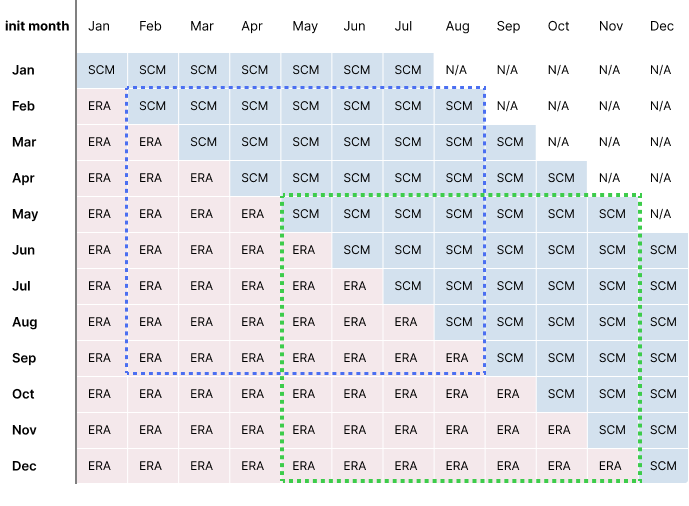

In [5]:
from IPython.display import Image
Image(filename="era_scm_us_br_overview.png")

In [145]:
li = []
for month in range(list(crop_season_in_months)[0], list(crop_season_in_months)[1]+1):
    ecmwf = pd.read_csv("../data/ECMWF/{}/ecmwf_csv/ecmwf_{}.csv".format(ecmwf_country, number_to_month[month]))
    ecmwf = preprocess.format_ecmwf_columns(ecmwf)
    ecmwf = preprocess.filter_by_crop_season(ecmwf, crop_season_in_days_of_year)
    ecmwf = preprocess.resample_ecmwf(ecmwf, crop_season_in_days_of_year)
    ecmwf, first_time_step = preprocess.assign_ecmwf_forecasts_to_adm_units(ecmwf, country_gpd_crop)
    era_pivot = preprocess.pivot_era(era_resampled.loc[era_resampled["time_step"] < first_time_step])
    era_ecmwf = era_pivot.merge(ecmwf, on=["adm_id", "harvest_year"], how="right")
    li.append(era_ecmwf)
era_end_of_season = preprocess.create_end_of_season(era_resampled, crop_season_in_months)
li.append(era_end_of_season)
era_ecmwf = pd.concat(li, ignore_index=True)
era_ecmwf.sample(5)

,adm_id,init_date,tavg_16,tavg_17,tavg_18,tavg_19,tavg_20,tavg_21,tavg_22,tavg_23,...,prec_33,prec_34,prec_35,prec_36,prec_37,prec_38,prec_39,prec_40,prec_41,harvest_year
153210,BR2928901,2018-12-01,23.033771,23.383404,21.892871,23.712843,22.572610,21.273396,21.258385,21.590333,...,0.014488,0.168976,0.877329,8.091839,4.189144,12.343110,9.857850,1.798346,9.205067,2018
112812,BR4112751,2003-10-01,18.943456,20.109835,16.140120,18.543228,20.698223,18.249076,17.508123,15.890747,...,4.635843,0.654153,7.612809,4.546240,5.308428,4.719645,5.044060,5.596751,6.456539,2003
455,BR4102000,2017-05-01,20.851425,18.373289,18.870554,18.078996,17.418503,17.121430,16.870766,16.872396,...,5.931550,5.882719,6.557894,7.711125,4.579042,6.328095,5.385841,6.099001,6.807295,2017
141159,BR4209508,2021-11-01,14.255218,13.680954,13.143652,16.014919,12.158470,13.546357,10.408412,12.322036,...,1.919996,11.301227,5.682489,5.117490,1.741246,2.289995,3.906911,4.034976,5.451239,2021
131098,BR4323606,2019-10-01,16.321543,16.606592,15.420019,15.332455,19.086871,16.048537,13.851220,8.286243,...,0.042500,9.584999,3.924885,5.982315,6.946301,5.463289,5.616467,5.388241,5.746190,2019


# EXPORT

In [137]:
era_ecmwf.to_csv("../data/preprocessed/{}/ecmwf_era_{}_{}.csv".format(ecmwf_country, crop, ecmwf_country), index=False)

### Overmatter

For bias-adjustment:

In [ ]:
# ERA data for forecast period used for CDF estimation
era_forecast_period = preprocess.pivot_era(era_resampled.loc[era_resampled["time_step"] >= first_time_step])
era_reference = era_forecast_period.loc[era_forecast_period["harvest_year"].isin(test_years) == False].sort_values(by=["adm_id", "harvest_year"]).reset_index(drop=True)
# ECMWF reference for CDF estimation that will not be adjusted
ecmwf_reference = ecmwf.loc[ecmwf["harvest_year"].isin(test_years) == False].sort_values(by=["adm_id", "harvest_year"]).reset_index(drop=True).copy()

features = [c for c in ecmwf_reference.columns  if ("prec"in c) or ("tavg" in c) or ("tmin" in c) or ("tmax" in c)]
ecmwf_adjusted = pd.DataFrame(index=ecmwf.set_index(["adm_id", "harvest_year", "init_date"]).index, columns=features).sort_index()
counter = 1
for adm_id in relevant_adm_ids:
    print(round(counter / len(relevant_adm_ids), 4) * 100, "%")
    counter += 1
    if adm_id in ['BR1300805', 'BR3518701']:
        continue
    for feature in features:
        era_cdf = era_reference.loc[era_reference["adm_id"] == adm_id, feature] 
        ecmwf_cdf = ecmwf_reference.loc[ecmwf_reference["adm_id"] == adm_id, feature] 
        ecmwf_to_adjust = ecmwf.loc[(ecmwf["adm_id"] == adm_id), feature]    
        #print(adm_id, feature, era_cdf.mean(), ecmwf_cdf.mean(), era_cdf.var(), ecmwf_cdf.var())
        
        if ("t" in feature):
                try:
                    ecmwf_adjusted.loc[(adm_id), feature] = preprocess.normal_correction(era_cdf, ecmwf_cdf, ecmwf_to_adjust)
                except:
                    print(ecmwf_to_adjust)
                    raise    
        elif ("prec" in feature):
                ecmwf_adjusted.loc[(adm_id), feature] =ecmwf_to_adjust * era_reference.mean() / ecmwf_cdf.mean()
        